In [ ]:
import os
import json
import shutil
from sklearn.model_selection import train_test_split

def create_dataset_split(data_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Chia dữ liệu thành train, test, validation và tạo file metadata.jsonl.
    
    Args:
        data_dir (str): Thư mục gốc chứa annotations/ và images/
        output_dir (str): Thư mục đầu ra (dataset_split/)
        train_ratio (float): Tỷ lệ dữ liệu cho tập train
        val_ratio (float): Tỷ lệ dữ liệu cho tập validation
        test_ratio (float): Tỷ lệ dữ liệu cho tập test
    """
    # Đảm bảo tỷ lệ hợp lệ
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-5, "Tổng tỷ lệ phải bằng 1.0"

    # Đường dẫn đến thư mục annotations và images
    annotations_dir = os.path.join(data_dir, "annotations")
    images_dir = os.path.join(data_dir, "images")
    
    # Tạo danh sách các file ảnh và file JSON
    image_files = [f for f in os.listdir(images_dir) if f.endswith((".jpg", ".png"))]
    json_files = [f for f in os.listdir(annotations_dir) if f.endswith(".json")]
    
    # Ghép các file ảnh và JSON dựa trên tên
    paired_files = []
    for img_file in image_files:
        # Tìm file JSON tương ứng
        json_file = img_file.rsplit(".", 1)[0] + ".json"
        if json_file in json_files:
            paired_files.append((img_file, json_file))
        else:
            print(f"Cảnh báo: Không tìm thấy file JSON cho ảnh {img_file}, bỏ qua.")
    
    # Chia dữ liệu thành train, validation, test
    train_pairs, temp_pairs = train_test_split(
        paired_files,
        train_size=train_ratio,
        random_state=2022  # Đảm bảo lặp lại được
    )
    val_ratio_adjusted = val_ratio / (val_ratio + test_ratio)
    val_pairs, test_pairs = train_test_split(
        temp_pairs,
        train_size=val_ratio_adjusted,
        random_state=2022
    )
    
    # Tạo thư mục đầu ra
    splits = {
        "train": train_pairs,
        "validation": val_pairs,
        "test": test_pairs
    }
    
    for split, pairs in splits.items():
        split_dir = os.path.join(output_dir, split)
        os.makedirs(split_dir, exist_ok=True)
        
        # Tạo file metadata.jsonl
        metadata_path = os.path.join(split_dir, "metadata.jsonl")
        with open(metadata_path, "w", encoding="utf-8") as f:
            for img_file, json_file in pairs:
                # Đọc file JSON
                with open(os.path.join(annotations_dir, json_file), "r", encoding="utf-8") as jf:
                    annotation = json.load(jf)
                
                # Tạo gt_parse (định dạng Document Parsing)
                gt_parse = {}
                for key, value in annotation.items():
                    gt_parse[key] = value  # Điều chỉnh tùy theo cấu trúc annotation của bạn
                
                # Tạo dòng metadata
                metadata = {
                    "file_name": img_file,
                    "ground_truth": json.dumps({"gt_parse": gt_parse}, ensure_ascii=False)
                }
                f.write(json.dumps(metadata, ensure_ascii=False) + "\n")
                
                # Sao chép file ảnh vào thư mục split
                src_img_path = os.path.join(images_dir, img_file)
                dst_img_path = os.path.join(split_dir, img_file)
                shutil.copy2(src_img_path, dst_img_path)
        
        print(f"Đã tạo split {split} với {len(pairs)} mẫu tại {split_dir}")

if __name__ == "__main__":
    data_dir = "data"
    output_dir = "dataset"
    create_dataset_split(data_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15)

In [ ]:
!python test.py --dataset_name_or_path D:/Private/Project/kaggle/LabAI/Donut/donut/dataset --pretrained_model_name_or_path D:/Private/Project/kaggle/LabAI/Donut/donut/result_new/train_cord/test_experiment --save_path result/output.json



c:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 586 examples [00:00, 6430.57 examples/s]
Generating validation split: 73 examples [00:00, 6100.99 examples/s]
Generating test split: 74 examples [00:00, 5668.19 examples/s]


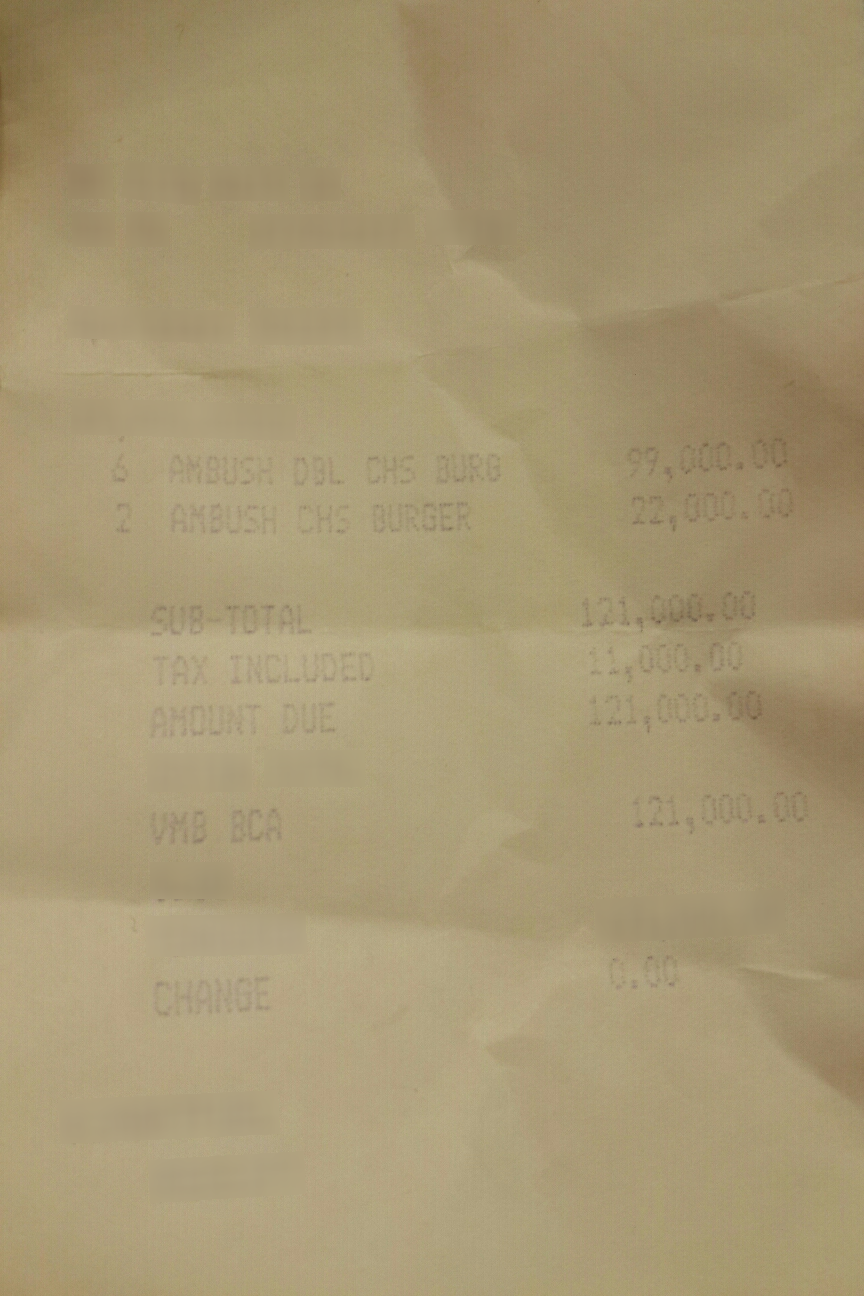

In [1]:
from datasets import load_dataset

dataset = load_dataset("cord_dataset")
image = dataset['test'][0]['image']
image

In [2]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")

c:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [3]:
from PIL import Image

# image = Image.open(r"D:\Private\Project\kaggle\LabAI\Donut\donut\data\images\00093726.png").convert("RGB")
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)


torch.Size([1, 3, 1280, 960])


In [4]:
import torch

task_prompt = "<s_cord-v2>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

outputs = model.generate(pixel_values.to(device),
                               decoder_input_ids=decoder_input_ids.to(device),
                               max_length=model.decoder.config.max_position_embeddings,
                               early_stopping=True,
                               pad_token_id=processor.tokenizer.pad_token_id,
                               eos_token_id=processor.tokenizer.eos_token_id,
                               use_cache=True,
                               num_beams=1,
                               bad_words_ids=[[processor.tokenizer.unk_token_id]],
                               return_dict_in_generate=True,
                               output_scores=True,)

In [5]:
import re

sequence = processor.batch_decode(outputs.sequences)[0]
sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
print(sequence)

<s_menu><s_nm> AMBUSHOUS DURGER</s_nm><s_cnt> 6</s_cnt><s_price> 121.000.00</s_price></s_menu><s_sub_total><s_subtotal_price> 121.000.00</s_subtotal_price></s_sub_total><s_total><s_total_price> 121.000.00</s_total_price></s_total>


In [6]:
processor.token2json(sequence)


{'menu': {'nm': 'AMBUSHOUS DURGER', 'cnt': '6', 'price': '121.000.00'},
 'sub_total': {'subtotal_price': '121.000.00'},
 'total': {'total_price': '121.000.00'}}